# Functions to save or load embeddings

**Function to store numpy embeddings in a .csv file**

In [1]:
import csv

def save_embedding_label_dataset(dataset: str, embedding_type: str, model_version:str, X, y):    
    with open(f"{dataset}/{model_version}-{embedding_type}.csv", "w", newline='') as f:
        writer = csv.writer(f)
        for xi, yi in zip(X, y):
            writer.writerow(list(xi) + [yi])

**Function to load embeddings from a .csv to a numpy embeddings**

In [2]:
def load_embedding_label_dataset(dataset: str, embedding_type: str, model_version: str):
    data = np.loadtxt(f"{dataset}/{model_version}-{embedding_type}.csv", delimiter=",")
    X = data[:, :-1]
    y = data[:, -1]
    
    return X,y

# MODEL 2, DATASET 2, EMBEDDING SUPREMO

In [3]:
model_version = "3"
dataset_folder = "onback_onstomach_v2"
embedding_type = "supremo"

**Import dependencies**

In [4]:
import numpy as np
from ultralytics import YOLO

import os
from pathlib import Path
import cv2

In [5]:
def move_to_project_folder(file: str):
    possible_paths = [
        Path().resolve(),
        Path("/home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project"),
        Path(" ")  # percorso di Lore
    ]

    for path in possible_paths:
        try:
            full_path = path / file
            if full_path.exists():
                os.chdir(path)
                print(f"Moved to {path}")
                break

        except FileNotFoundError:
            pass
    else:
        raise RuntimeError("No model loaded, all paths were invalid.")

move_to_project_folder("mod3data2_SUPREMO.ipynb")
import embeddings

Moved to /home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project


**Load model and process the dataset (extract keypoints from every image in the dataset and the corresponding label)**

In [ ]:
emb_builder = embeddings.EmbeddingBuilder(f"{model_version}.weights/best.pt", dataset_folder)
emb_builder.process_dataset()

**Load model and load processed keypoints and lables (keypoints from every image in the dataset and the corresponding label)**

In [6]:
emb_builder = embeddings.EmbeddingBuilder(f"{model_version}.weights/best.pt", dataset_folder)
emb_builder.extract_dataset_info()
emb_builder.load_keypoints_and_y()

Moved to /home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project
Keypoints and labels loaded succesfully, in particular there are 1506 files in the dataset


In [7]:
y = np.array(emb_builder.y)
X, features = emb_builder.embedding_all_features()
X = np.array(X)

save_embedding_label_dataset(dataset_folder, embedding_type,model_version, X, y)

0%-->    0 / 1506 files processed
6%-->    100 / 1506 files processed
13%-->    200 / 1506 files processed
19%-->    300 / 1506 files processed
26%-->    400 / 1506 files processed
33%-->    500 / 1506 files processed
39%-->    600 / 1506 files processed
46%-->    700 / 1506 files processed
53%-->    800 / 1506 files processed
59%-->    900 / 1506 files processed
66%-->    1000 / 1506 files processed
73%-->    1100 / 1506 files processed
79%-->    1200 / 1506 files processed
86%-->    1300 / 1506 files processed
92%-->    1400 / 1506 files processed
99%-->    1500 / 1506 files processed
FINISHED:
-> 1506 embedding created


# RANDOM FOREST con feature selection

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

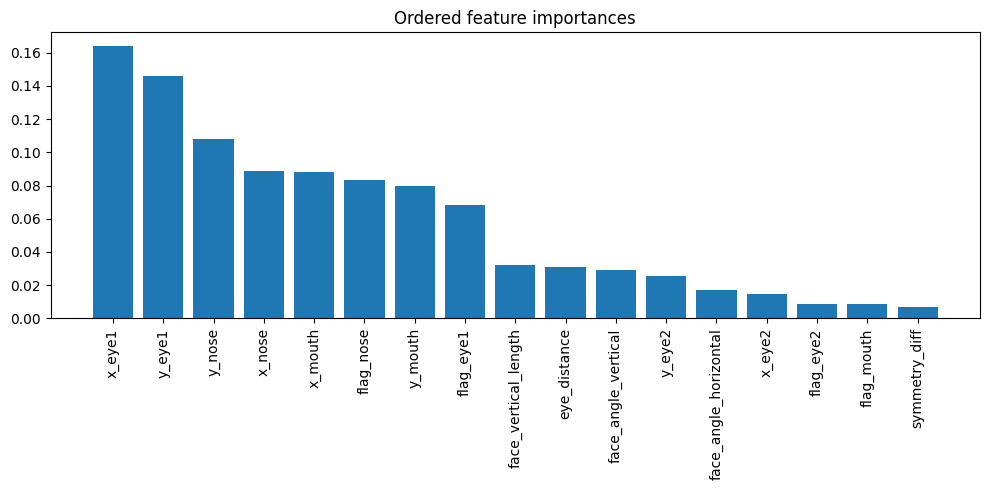

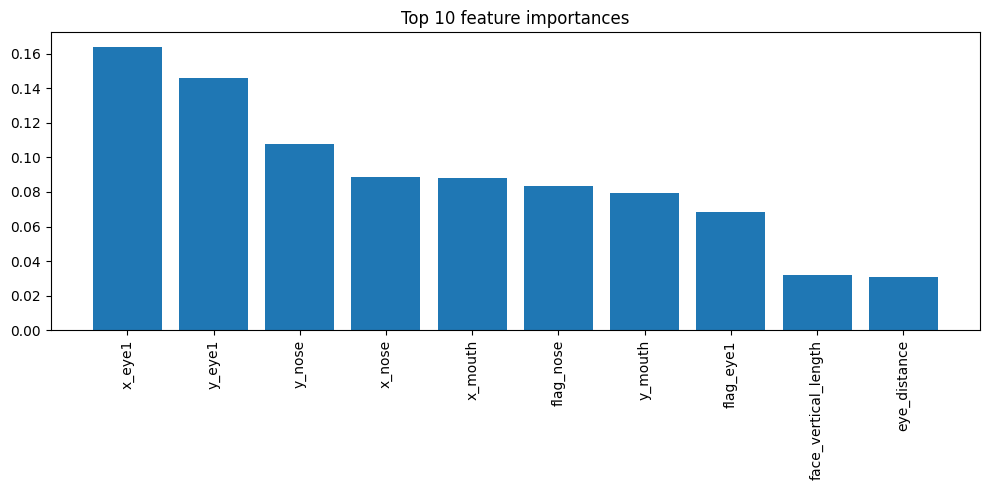

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
n_features = len(indices)

# Visualize all feature importances
plt.figure(figsize=(10, 5))
plt.title("Ordered feature importances")
plt.bar(range(n_features), importances[indices[:n_features]])
plt.xticks(range(n_features), [f"{features[i]}" for i in indices[:n_features]], rotation=90)
plt.tight_layout()


# Visualize top 10 feature importances
plt.figure(figsize=(10, 5))
plt.title("Top 10 feature importances")
plt.bar(range(10), importances[indices[:10]])
plt.xticks(range(10), [f"{features[i]}" for i in indices[:10]], rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Select the 10 most important features
top_k = 10
top_features_idx = indices[:top_k]

# Filter dataset
X_train_selected = X_train[:, top_features_idx]
X_test_selected = X_test[:, top_features_idx]

clf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
clf_reduced.fit(X_train_selected, y_train)

y_pred_reduced = clf_reduced.predict(X_test_selected)
classes_mlp = emb_builder.classes_mlp

# Evaluate
print(f"\nDataset labels:----------------------------------------\n{classes_mlp}\n")
print(f"Report-------------------------------------------------")
print(classification_report(y_test, y_pred_reduced, target_names=classes_mlp.keys()))


Dataset labels:----------------------------------------
{'baby_on_back': 1, 'baby_on_stomach': 2}

Report-------------------------------------------------
                 precision    recall  f1-score   support

   baby_on_back       0.92      0.50      0.64       115
baby_on_stomach       0.76      0.97      0.85       187

       accuracy                           0.79       302
      macro avg       0.84      0.73      0.75       302
   weighted avg       0.82      0.79      0.77       302

